### Business Problem



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preprocessing

Read the data into dataframe and only keep two columns, the review text and the rating columns. Remove any reviews with no rating and rating with no review text from the dataframe.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras

df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SU23 Deep Learning/Final Project/Yelp Restaurant Reviews.csv",index_col=0)
df=df.loc[:,["Review Text","Rating"]].dropna().reset_index(drop=True)

In [ ]:
#The number of reviews after clearning data
len(df)

19896

In [ ]:
#Look at the distribution of reviews in rating classes
df["Rating"].value_counts()

5    10883
4     4447
3     2069
2     1280
1     1217
Name: Rating, dtype: int64

We have an uneven distribution of ratings because about 55% of the reviews rated 5. This happens may because happy customers are more willing to leave their comments for the restaurant. Therefore, in order to improve the respresenting power of other subgroups, who leaves lower ratings, we can do a stratified sampling. The stratified sampling technique would help us to ensure the distribution of classes in the dataset is preserved in the sample that I used for training the model.

# Prepare training and validation data

Build a model with 80% training dataset for model training and 20% validation dataset for model assessment.

I used the review text as predictor and the ratings as responses to my model.

In [ ]:
from sklearn.model_selection import train_test_split
rev=df["Review Text"]
target=df["Rating"]
x_train, x_test, y_train, y_test = train_test_split(rev,target,test_size=0.2,random_state=0,stratify=target)

**Assumption:**
Treat rating as a continuous variable.

Calculate the mean absolute percent error by using the average rating of the test dataset.

In [ ]:
average_rating=y_test.mean()
mae=0
for rating in y_test:
    mae+=abs(rating-average_rating)

print(mae/len(y_test))

0.9504893815812724


# Feature Extraction and Tokenization with padding

Decide the number of words to consider as features, the maximum sequence length of words to select from each sentence, and the number of rows of input for each step in each epoch.

To let the model understand the process the text data, we break down the sentence into individual units by tokenization.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

#Text sampling
max_features = 10000
maxlen = 50
batch_size = 32

#Tokenizing
tokenizer=Tokenizer(max_features,oov_token="<OOV>")
tokenizer.fit_on_texts(x_train)
X_train=tokenizer.texts_to_sequences(x_train)
X_test=tokenizer.texts_to_sequences(x_test)
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

#Turns tockenized texts into padded sequences
print('Pad sequences (samples x text length)')
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

15916 train sequences
3980 test sequences
Pad sequences (samples x text length)
X_train shape: (15916, 50)
X_test shape: (3980, 50)


# Build original model with SimpleRNN

Because the words in review text have strong dependence on each other regarding the word sequence, the use of word embeddings is crucial to capture the semantic relationships between words. Word embedding enable machine learning models to understand the meaning of words and their context, which is essential for natrual language processing (NLP).

Since the Simple Recurrent Neural Network (SimpleRNN) provides a relatively straightforward architecture to process sequential data, I used three hidden layers of SimpleRNN to build my original prediction model. Then improve my model based on the result.

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense

model = Sequential()
embedding_dim = 64
model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
model.add(SimpleRNN(64, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(16))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mae', metrics='mape') #mape: Mean Absolute Percentage Error
history = model.fit(X_train, y_train,
                    epochs=10,
                    steps_per_epoch = 256,
                    batch_size=batch_size,
                   validation_data=(X_test,y_test))

keras.backend.clear_session()
del model

Epoch 1/10
256/256 [==============================] - 23s 63ms/step - loss: 1.0153 - mape: 47.0323 - val_loss: 0.8705 - val_mape: 46.5307
Epoch 2/10
256/256 [==============================] - 14s 55ms/step - loss: 0.8600 - mape: 45.3727 - val_loss: 0.8690 - val_mape: 46.4597
Epoch 3/10
256/256 [==============================] - 15s 57ms/step - loss: 0.8416 - mape: 41.6646 - val_loss: 1.1647 - val_mape: 48.1261
Epoch 4/10
256/256 [==============================] - 14s 54ms/step - loss: 0.8431 - mape: 39.9483 - val_loss: 0.8712 - val_mape: 39.0410
Epoch 5/10
256/256 [==============================] - 15s 60ms/step - loss: 0.6424 - mape: 31.5730 - val_loss: 0.7870 - val_mape: 37.7758
Epoch 6/10
256/256 [==============================] - 15s 57ms/step - loss: 0.5931 - mape: 27.7309 - val_loss: 0.7820 - val_mape: 35.0102
Epoch 7/10
256/256 [==============================] - 14s 55ms/step - loss: 0.4627 - mape: 20.9376 - val_loss: 0.6714 - val_mape: 30.2216
Epoch 8/10
256/256 [==============

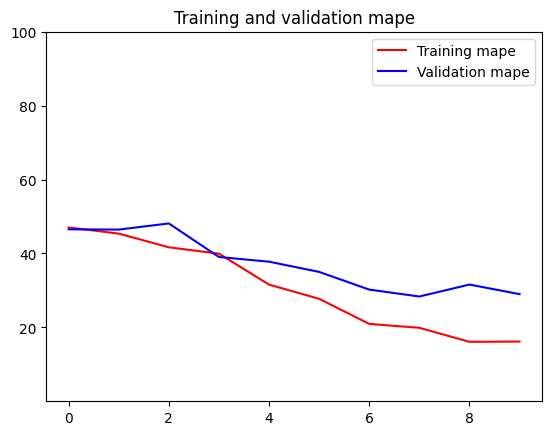

In [ ]:
import matplotlib.pyplot as plt

mape = history.history['mape']
val_mape = history.history['val_mape']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, mape, 'r', label='Training mape')
plt.plot(epochs, val_mape, 'b', label='Validation mape')
plt.title('Training and validation mape')
plt.legend()
plt.ylim(ymax=100,ymin=0.01)

plt.show()

**Interpret the result:**

We have an overfitting problem here because there is a big gap between training and validation mape. The training mape is better than validation mape, but both of them are higher than 15%. Therefore, we want to reduce both of the mapes and close the gap between them to solve the problem.

SimpleRNN can cause the Vanishing Gradient Problem. Because when gradients (or weights) are propagated backward through multiple time steps, they can become very small. However, SimpleRNN model is still useful for capturing short-term dependencies in sequences where information from recent time is important. Therefore, the model will have difficulty learning long-range dependencies. We need a model that is more powerful to capture long-term dependencies with better feature extraction.

# Improve model with CNN

Using word embeddings and CNN methods for prediction.
With everthing else fixed, I replaced the 3 layers of SimpleRNN with convolutional nueral network and maxpooling.

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding
from keras import layers

model = Sequential()
embedding_dim = 64
model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(64, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(optimizer='adam', loss='mae', metrics='mape') #mape: Mean Absolute Percentage Error
history = model.fit(X_train, y_train,
                    epochs=10,
                    steps_per_epoch = 256,
                    batch_size=batch_size,
                   validation_data=(X_test,y_test))

keras.backend.clear_session()
del model

Epoch 1/10
256/256 [==============================] - 7s 22ms/step - loss: 1.0408 - mape: 40.4369 - val_loss: 0.7477 - val_mape: 32.6598
Epoch 2/10
256/256 [==============================] - 6s 22ms/step - loss: 0.7248 - mape: 32.0222 - val_loss: 0.7201 - val_mape: 32.2993
Epoch 3/10
256/256 [==============================] - 6s 25ms/step - loss: 0.6334 - mape: 27.4783 - val_loss: 0.7042 - val_mape: 29.6685
Epoch 4/10
256/256 [==============================] - 5s 19ms/step - loss: 0.6157 - mape: 26.7594 - val_loss: 0.6569 - val_mape: 27.4337
Epoch 5/10
256/256 [==============================] - 7s 27ms/step - loss: 0.5129 - mape: 20.8982 - val_loss: 0.6545 - val_mape: 28.4638
Epoch 6/10
256/256 [==============================] - 5s 21ms/step - loss: 0.5065 - mape: 20.4727 - val_loss: 0.6321 - val_mape: 26.5770
Epoch 7/10
256/256 [==============================] - 6s 24ms/step - loss: 0.4283 - mape: 17.3148 - val_loss: 0.6351 - val_mape: 26.3498
Epoch 8/10
256/256 [=====================

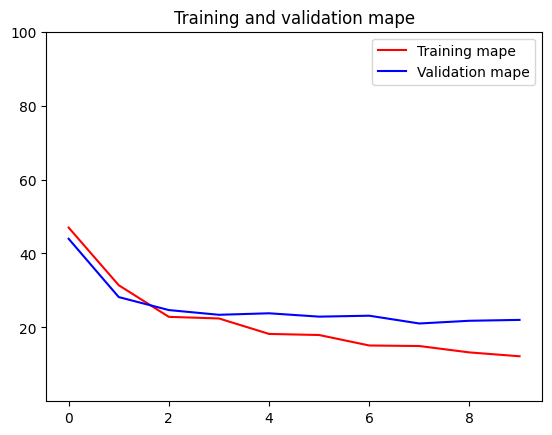

In [ ]:
import matplotlib.pyplot as plt

mape = history.history['mape']
val_mape = history.history['val_mape']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, mape, 'r', label='Training mape')
plt.plot(epochs, val_mape, 'b', label='Validation mape')
plt.title('Training and validation mape')
plt.legend()
plt.ylim(ymax=100,ymin=0.01)

plt.show()

**Interpret the result:**

The training mape is reduced to 14% but the validation mape is still high at 25%. Therefore, combining embedding and CNN method cannot help close the gap between training mape and validation mape.

CNNs offer advantages such as automatic feature extraction and transaction invariance. However, they may not be helpful for detecting long-range dependencies or understanding complex sequential relationships in data. For such tasks, recurrent neural networks (RNNs) will be more helpful.

# Improve model with LSTM
Since LSTM method were specifically designed to capture long-range dependencis and relationships within the sequences, I replaced it with the CNNs layer to improve my model.
Also, I added dropout and recurrent dropout for the LSTM layer to regularize the model and improve generalization. However, the underfitting problem still exist because the limitation of the sampling data.

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding
from keras import layers

model = Sequential()
embedding_dim = 64
model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
model.add(layers.LSTM(32,dropout=0.2,recurrent_dropout=0.2,return_sequences=True))
model.add(layers.LSTM(16))
model.add(layers.Dense(1))
model.compile(optimizer='adam', loss='mae', metrics='mape')
history = model.fit(X_train, y_train,
                    epochs=10,
                    steps_per_epoch = 256,
                    batch_size=batch_size,
                    validation_data=(X_test,y_test))
keras.backend.clear_session()
del model

Epoch 1/10
256/256 [==============================] - 38s 125ms/step - loss: 1.1389 - mape: 48.8510 - val_loss: 0.8761 - val_mape: 45.7280
Epoch 2/10
256/256 [==============================] - 30s 119ms/step - loss: 0.8605 - mape: 45.6042 - val_loss: 0.8411 - val_mape: 42.8500
Epoch 3/10
256/256 [==============================] - 31s 122ms/step - loss: 0.6355 - mape: 28.8672 - val_loss: 0.5817 - val_mape: 25.2644
Epoch 4/10
256/256 [==============================] - 31s 122ms/step - loss: 0.5540 - mape: 23.5896 - val_loss: 0.5654 - val_mape: 25.9233
Epoch 5/10
256/256 [==============================] - 31s 120ms/step - loss: 0.4678 - mape: 18.9460 - val_loss: 0.5409 - val_mape: 24.4384
Epoch 6/10
256/256 [==============================] - 31s 119ms/step - loss: 0.4527 - mape: 18.4478 - val_loss: 0.5130 - val_mape: 20.1942
Epoch 7/10
256/256 [==============================] - 31s 119ms/step - loss: 0.4042 - mape: 15.5645 - val_loss: 0.5281 - val_mape: 21.7868
Epoch 8/10
256/256 [=======

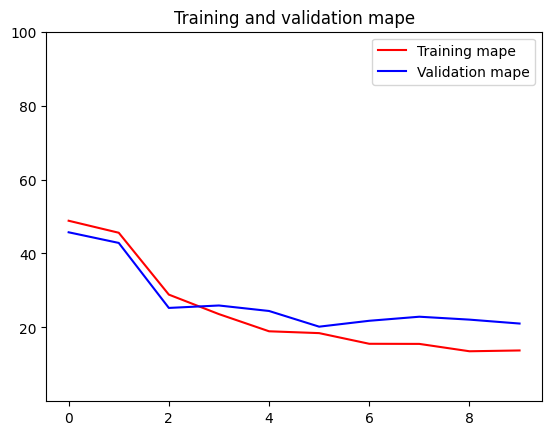

In [ ]:
import matplotlib.pyplot as plt

mape = history.history['mape']
val_mape = history.history['val_mape']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, mape, 'r', label='Training mape')
plt.plot(epochs, val_mape, 'b', label='Validation mape')
plt.title('Training and validation mape')
plt.legend()
plt.ylim(ymax=100,ymin=0.01)

plt.show()

**Interpret the result:**

Compared with the result from the previous model built with CNN and maxpooling, the gap between training mape and validation mape become smaller after we replaced CNNs with LSTM method. The result indicates that using purely LSTM method with word embedding is more helpful in prediction model than using purely CNN method with word embedding.


# Improve model wtih CNN and LSTM

Since we lost the advantage of CNN method for feature extraction, I'm building a model with CNN and LSTM to further improve the result.

In this model, I used two convolutional layers with one maxpooling and two LSTM layers with dropout and recurrent dropout of 20% in the first LSTM layer.

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Conv1D, MaxPooling1D
from keras.layers import Dense

model = Sequential()
embedding_dim = 64
model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(64, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.LSTM(32,dropout=0.2,recurrent_dropout=0.2,return_sequences=True))
model.add(layers.LSTM(16))
model.add(layers.Dense(1))

model.compile(optimizer='adam', loss='mae', metrics='mape')
history = model.fit(X_train, y_train,
                    epochs=10,
                    steps_per_epoch = 256,
                    batch_size=batch_size,
                   validation_data=(X_test,y_test))
keras.backend.clear_session()
del model

Epoch 1/10
256/256 [==============================] - 20s 55ms/step - loss: 1.0865 - mape: 46.9961 - val_loss: 0.8341 - val_mape: 43.9678
Epoch 2/10
256/256 [==============================] - 13s 51ms/step - loss: 0.6698 - mape: 31.4069 - val_loss: 0.6123 - val_mape: 28.1983
Epoch 3/10
256/256 [==============================] - 14s 55ms/step - loss: 0.5236 - mape: 22.8515 - val_loss: 0.5728 - val_mape: 24.6844
Epoch 4/10
256/256 [==============================] - 13s 52ms/step - loss: 0.5214 - mape: 22.4162 - val_loss: 0.5653 - val_mape: 23.4075
Epoch 5/10
256/256 [==============================] - 13s 51ms/step - loss: 0.4449 - mape: 18.2324 - val_loss: 0.5565 - val_mape: 23.8142
Epoch 6/10
256/256 [==============================] - 13s 50ms/step - loss: 0.4467 - mape: 17.9362 - val_loss: 0.5437 - val_mape: 22.9081
Epoch 7/10
256/256 [==============================] - 11s 44ms/step - loss: 0.3859 - mape: 15.1026 - val_loss: 0.5377 - val_mape: 23.1604
Epoch 8/10
256/256 [==============

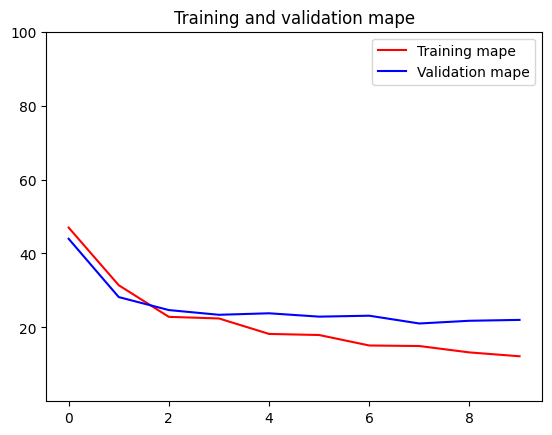

In [ ]:
import matplotlib.pyplot as plt

mape = history.history['mape']
val_mape = history.history['val_mape']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, mape, 'r', label='Training mape')
plt.plot(epochs, val_mape, 'b', label='Validation mape')
plt.title('Training and validation mape')
plt.legend()
plt.ylim(ymax=100,ymin=0.01)

plt.show()

# Improve model with CNN and Bidirectional LSTM

By using Bidirectional for LSTM layers, we processed the input sequence in both forward and backward directions. This ensured that the network receives information from both the past and the future context at each time step. Therefore, using Bidirectional for LSTM layer will help us to capture more context and dependencies in the data.

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Conv1D, MaxPooling1D
from keras.layers import Dense

model = Sequential()
embedding_dim = 64
model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(64, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.Bidirectional(
    layers.LSTM(32,dropout=0.2,recurrent_dropout=0.2,return_sequences=True)))
model.add(layers.Bidirectional(layers.LSTM(16)))
model.add(layers.Dense(1))

model.compile(optimizer='adam', loss='mae', metrics='mape')
history = model.fit(X_train, y_train,
                    epochs=10,
                    steps_per_epoch = 256,
                    batch_size=batch_size,
                   validation_data=(X_test,y_test))
keras.backend.clear_session()
del model

Epoch 1/10
256/256 [==============================] - 34s 83ms/step - loss: 0.9971 - mape: 44.4872 - val_loss: 0.6659 - val_mape: 29.9757
Epoch 2/10
256/256 [==============================] - 20s 79ms/step - loss: 0.6112 - mape: 27.7034 - val_loss: 0.5850 - val_mape: 27.2908
Epoch 3/10
256/256 [==============================] - 22s 84ms/step - loss: 0.5148 - mape: 22.1400 - val_loss: 0.5579 - val_mape: 25.1743
Epoch 4/10
256/256 [==============================] - 21s 84ms/step - loss: 0.5103 - mape: 21.8301 - val_loss: 0.5599 - val_mape: 25.6061
Epoch 5/10
256/256 [==============================] - 20s 76ms/step - loss: 0.4373 - mape: 18.1738 - val_loss: 0.5510 - val_mape: 22.1607
Epoch 6/10
256/256 [==============================] - 19s 73ms/step - loss: 0.4500 - mape: 18.1460 - val_loss: 0.5408 - val_mape: 21.9644
Epoch 7/10
256/256 [==============================] - 21s 81ms/step - loss: 0.3871 - mape: 15.0900 - val_loss: 0.5369 - val_mape: 21.2470
Epoch 8/10
256/256 [==============

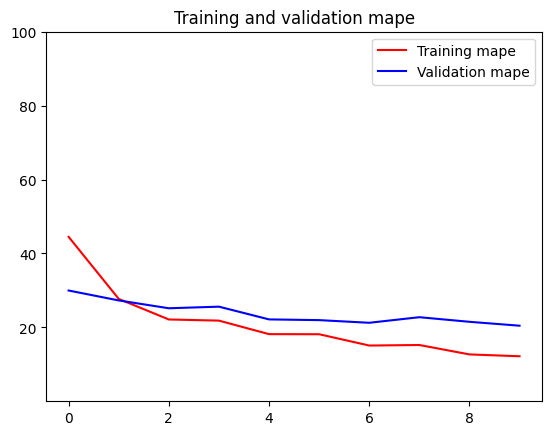

In [ ]:
import matplotlib.pyplot as plt

mape = history.history['mape']
val_mape = history.history['val_mape']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, mape, 'r', label='Training mape')
plt.plot(epochs, val_mape, 'b', label='Validation mape')
plt.title('Training and validation mape')
plt.legend()
plt.ylim(ymax=100,ymin=0.01)

plt.show()

# Save Model

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/SU23 Deep Learning/Final Project/YelpRatingPrediction.h5")